## Предсказание запаса реактивности на основе изотопных составов топливных зон

In [1]:
# Импоортируем библиотеки
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import LinearSVR, SVR
import tensorflow as tf

In [2]:
# Считываем подготовленный csv
main_df = pd.read_csv('final.csv', sep=',', index_col=0 )

In [3]:
#Посмотрим на кол-во объектов и признаков
main_df.shape

(91, 172802)

Итого 91 различный вариант, помиотрим хватит ли такого кол-ва

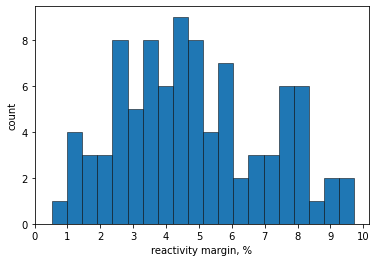

In [214]:
# Построим разброс значений целевой переменной
plt.hist(main_df.reactivity_margin, bins=20, linewidth=0.5, edgecolor="black")
plt.xlabel('reactivity margin, %')
plt.ylabel('count')
plt.xticks(list(range(11)))
plt.show()

В целом явно выпадающих значений нет, большая часть значений лежит от 3 до 5%, что соответствуеют типичному циклу работы реактора

In [215]:
# Поскольку реактивность зависит только от Кэф, удаляем данный столбец
main_df.drop(columns=['Keff'], inplace=True)
target = main_df.pop('reactivity_margin')
# Разделяем данные на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(main_df, target, test_size=0.3, random_state=7)
# Проверяем раззмерности обуч. и тест. наборов
X_train.shape, X_test.shape

((63, 172800), (28, 172800))

## Sklearn модели

In [4]:
# Для начала протестируем самую простую модель наименьших квадратов, а также три модели посложнее, линейную модель,
# которая минимизирует лосс с помощью стохастического градиентного спуска, линейную модель опорных векторов и модель опорных
# векторов с ядерным трюком. Для более сложных моделей будем подбирать оптимальный параметры с помощью HalvingGridSearch
lr = LinearRegression(n_jobs=-1)

sgd = SGDRegressor()

sgd_params = {
    'penalty':['l2', 'elasticnet'],
    'alpha':[0.0001, 0.001, 0.005],
    'l1_ratio':[0.15, 0.25, 0.5, 0.65, 0.75],
    'fit_intercept':[True],
    'tol':[0.0005],
    'max_iter':[50000]
}

lin_svr = LinearSVR()
             
lin_svr_params = {
    'tol':[0.0005],
    'C':[0.1, 0.5, 1, 10],
    'max_iter':[50000]
}

svr = SVR()

svr_params = {
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'tol': [0.0005], 
    'C': np.logspace(-3,2, 6),
    'max_iter': [-1]
}


In [5]:
# Поскольку решается задача регрессии, то для поиска параметров можно ограничиться обычной k-блочной перекрестной проверкой
sss = KFold(n_splits=3, shuffle=True, random_state=7)

In [218]:
%%time 
# Обучаем модели
lr.fit(X_train, y_train)

sgd_search = HalvingGridSearchCV(estimator=sgd, 
                                 param_grid=sgd_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=7,
                                 n_jobs=-1).fit(X_train, y_train)

lin_svr_search = HalvingGridSearchCV(estimator=lin_svr, 
                                     param_grid=lin_svr_params,
                                     scoring='r2',
                                     cv=sss, 
                                     random_state=7,
                                     n_jobs=-1).fit(X_train, y_train)

svr_search = HalvingGridSearchCV(estimator=svr, 
                                 param_grid=svr_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=7,
                                 n_jobs=-1).fit(X_train, y_train)


Wall time: 4min 29s


In [219]:
#Глядя на ошибку обычной линейной модели, можно сделать вывод, что данная модель для решения задачи не подходит
mean_absolute_error(y_test, lr.predict(X_test))

494.363415440665

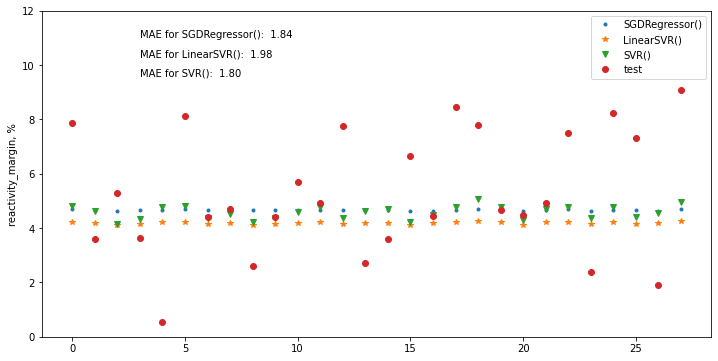

In [220]:
models = [sgd_search, lin_svr_search, svr_search]
markers = ['.', '*', 'v']
fig, ax = plt.subplots(figsize=(12,6))
for model, marker, y_text in zip(models, markers, [11,10.3,9.6]):
    y_pred = model.predict(X_test)
    ax.plot(y_pred, marker, label=(model.estimator))
    ax.text(s=f'MAE for {model.estimator}: {mean_absolute_error(y_test, y_pred): .2f}', x=3, y=y_text)
ax.plot([x for x in range(len(y_test))], y_test, 'o', label='test')
ax.set_ylabel('reactivity_margin, %')
ax.set_ylim(0, 12)
ax.legend()
plt.show()

## Вывод
Регрессионные модели способны предсказывать с довольно большой погрешностью, что может быть связано с влиянием различных ампульных устройств в отражателе, в особоенности ампулы в ячейке 6-4

In [2]:
# в файле final_with_ampules.csv помимо изотопных составов также имеется информация о ампуле в ячейке 6-4, которая
# уменьшает запас реактивности на порядка 2%. Это можно учесть просто вычев или прибавив данное значение, но 
# для начала можно попробовать учесть это простой индекацией наличия данной ампулы.
main_df2 = pd.read_csv('final_with_ampules.csv', sep=',', index_col=0 )

In [3]:
#Посчитаем кол-во вариантов с ампулой и без и соответствующие запасы
main_df2.groupby('ampule').agg({'Keff':'count', 'reactivity_margin':'mean'})

,Keff,reactivity_margin
ampule,,
0,22,4.867830
1,68,4.929305


In [4]:
main_df2.drop(columns=['Keff'], inplace=True)
target2 = main_df2.pop('reactivity_margin')

In [5]:
main_df2

,u235 in mat15563,u238 in mat15563,pu39 in mat15563,xe35 in mat15563,sm49 in mat15563,u235 in mat15564,u238 in mat15564,pu39 in mat15564,xe35 in mat15564,sm49 in mat15564,...,u238 in mat50121,pu39 in mat50121,xe35 in mat50121,sm49 in mat50121,u235 in mat50122,u238 in mat50122,pu39 in mat50122,xe35 in mat50122,sm49 in mat50122,ampule
0,0.001892,0.000258,0.000003,1.958600e-17,2.137700e-07,0.001875,0.000258,0.000003,2.014520e-17,2.179800e-07,...,0.000256,0.000004,1.096900e-17,2.244700e-07,0.001348,0.000256,0.000004,1.052840e-17,2.309600e-07,1
1,0.001892,0.000258,0.000003,1.958600e-17,2.137700e-07,0.001875,0.000258,0.000003,2.014520e-17,2.179800e-07,...,0.000256,0.000004,1.096900e-17,2.244700e-07,0.001348,0.000256,0.000004,1.052840e-17,2.309600e-07,1
2,0.001892,0.000258,0.000003,1.958600e-17,2.137700e-07,0.001875,0.000258,0.000003,2.014520e-17,2.179800e-07,...,0.000256,0.000004,1.096900e-17,2.244700e-07,0.001348,0.000256,0.000004,1.052840e-17,2.309600e-07,1
3,0.001892,0.000258,0.000003,1.958600e-17,2.137700e-07,0.001875,0.000258,0.000003,2.014520e-17,2.179800e-07,...,0.000256,0.000004,1.096900e-17,2.244700e-07,0.001348,0.000256,0.000004,1.052840e-17,2.309600e-07,1
4,0.001813,0.000258,0.000003,7.327330e-10,2.013030e-07,0.001787,0.000258,0.000004,8.135220e-10,2.038180e-07,...,0.000255,0.000004,9.868130e-10,1.867010e-07,0.001221,0.000256,0.000004,1.011630e-09,1.901750e-07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.002175,0.000266,0.000002,1.779910e-08,2.201420e-07,0.002160,0.000265,0.000002,1.841360e-08,2.198540e-07,...,0.000255,0.000002,1.834570e-08,2.094110e-07,0.001873,0.000255,0.000002,1.837000e-08,2.087810e-07,0
86,0.002167,0.000265,0.000002,1.882570e-08,1.879430e-07,0.002151,0.000265,0.000002,1.936170e-08,1.838570e-07,...,0.000255,0.000002,1.864140e-08,1.577260e-07,0.001860,0.000255,0.000002,1.866240e-08,1.560670e-07,0
87,0.002153,0.000265,0.000002,1.876570e-08,1.808310e-07,0.002135,0.000265,0.000002,1.932620e-08,1.770720e-07,...,0.000255,0.000002,1.844490e-08,1.550390e-07,0.001837,0.000255,0.000002,1.839130e-08,1.540870e-07,0
88,0.002105,0.000265,0.000002,5.905730e-13,2.360430e-07,0.002081,0.000265,0.000002,6.524290e-13,2.408400e-07,...,0.000255,0.000002,6.178070e-13,2.283580e-07,0.001773,0.000255,0.000002,6.377370e-13,2.296190e-07,0


In [5]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(main_df2, target2, test_size=0.2, random_state=7)

In [10]:
%%time
#В качестве первого шага применим аналогичные модели
sgd_search = HalvingGridSearchCV(estimator=sgd, 
                                 param_grid=sgd_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=9,
                                 n_jobs=-1).fit(X_train2, y_train2)

lin_svr_search = HalvingGridSearchCV(estimator=lin_svr, 
                                     param_grid=lin_svr_params,
                                     scoring='r2',
                                     cv=sss, 
                                     random_state=9,
                                     n_jobs=-1).fit(X_train2, y_train2)

svr_search = HalvingGridSearchCV(estimator=svr, 
                                 param_grid=svr_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=9,
                                 n_jobs=-1).fit(X_train2, y_train2)

Wall time: 6min 24s


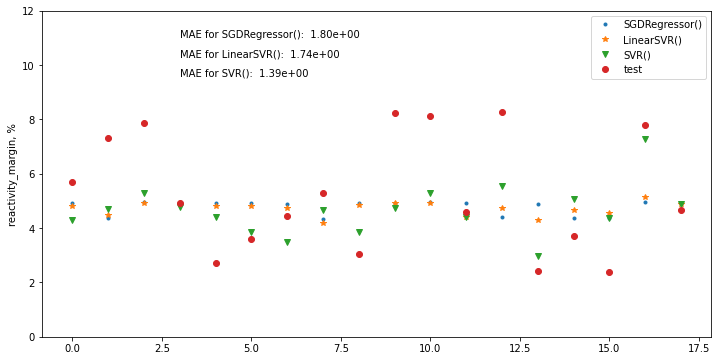

In [11]:
models = [sgd_search, lin_svr_search, svr_search]
markers = ['.', '*', 'v']
fig, ax = plt.subplots(figsize=(12,6))
for model, marker, y_text in zip(models, markers, [11,10.3,9.6]):
    y_pred = model.predict(X_test2)
    ax.plot(y_pred, marker, label=(model.estimator))
    ax.text(s=f'MAE for {model.estimator}: {mean_absolute_error(y_test2, y_pred): .2e}', x=3, y=y_text)
ax.plot([x for x in range(len(y_test2))], y_test2, 'o', label='test')
ax.set_ylabel('reactivity_margin, %')
ax.set_ylim(0, 12)
ax.legend()
plt.show()

## Вывод
Добавив 1 признак наличия ампулы к уже имеющимся **172800**, удалось **снизить** абсолютную ошибку с **2** до **1.4** <div>
**Наилучшей** моделью из рассмотренных оказалась **SVC**, что связано с большой нелинейностью зависимости целевой переменной от признаков

## Библиотека XGBoost + Optuna

In [8]:
# !pip install xgboost
# !pip install optuna
import xgboost as xgb
import optuna

In [9]:
def objective(trial, data=main_df2, label=target2):
    train_x, valid_x, train_y, valid_y = train_test_split(data, label, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 2,
        "objective": "reg:squarederror",
        "num_round": trial.suggest_int("num_round", 1000, 4000, step=500),
        # For larger dataset, approximate algorithm (approx) will be chosen.
        # Also it’s recommended to try hist and gpu_hist for higher performance with large dataset.
        "tree_method": "approx",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data. XGBoost would randomly sample half of the training data prior to growing trees
        # and this will prevent overfitting.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 2, 4, step=1)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    rmse = mean_squared_error(valid_y, preds, squared=False)
    return rmse

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300, timeout=None, n_jobs=3)

print("Number of finished trials: ", len(study.trials))
print(f"Best trial: {study.best_trial}") 

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-07 14:56:01,337] A new study created in memory with name: no-name-f73686d6-c19e-45a0-a444-e8ec0e43b58b
C:\Users\Anton\anaconda3\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-07-07 14:56:24,870] Trial 0 finished with value: 2.430555282752741 and parameters: {'num_round': 1800, 'booster': 'gblinear', 'lambda': 8.227760886309509e-05, 'alpha': 0.0005691009810988934, 'subsample': 0.49651343391372627, 'colsample_bytree': 0.4376722526734275}. Best is trial 0 with value: 2.430555282752741.
[I 2022-07-07 14:56:36,377] Trial 2 finished with value: 5.236896119942323 and parameters: {'num_round': 1800, 'booster': 'gbtree', 'lambda': 0.043488084432377165, 'alpha': 5.076240052645602e-06, 'subsample': 0.7655432660452626, 'colsample_bytree': 0.9498836492494249, 'max_depth': 2, 'min_child_weight': 3, 'eta': 0

[I 2022-07-07 15:00:21,699] Trial 18 finished with value: 5.390367561014091 and parameters: {'num_round': 1200, 'booster': 'gbtree', 'lambda': 9.967687997076664e-08, 'alpha': 0.06811103086406933, 'subsample': 0.9958571487362718, 'colsample_bytree': 0.5108706472997259, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.0005843056713221172, 'gamma': 2.1581692598993987e-05, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 1.0113901692984892.
[I 2022-07-07 15:00:21,995] Trial 19 finished with value: 4.9187118444559035 and parameters: {'num_round': 1200, 'booster': 'gbtree', 'lambda': 3.3044484485748855e-08, 'alpha': 0.02621618880297237, 'subsample': 0.9676690745966772, 'colsample_bytree': 0.5391917491143224, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.00073317502029619, 'gamma': 2.4762463159503173e-05, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 1.0113901692984892.
[I 2022-07-07 15:00:26,096] Trial 20 finished with value: 5.268041688835375 and parameters: {'num_roun

[I 2022-07-07 15:06:37,595] Trial 35 finished with value: 1.3384715711936834 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 3.146244115275389e-05, 'alpha': 0.0012308000148380633, 'subsample': 0.6126090558827442, 'colsample_bytree': 0.3336802323208302, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.6644770282947552, 'gamma': 0.04585402413811472, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0029788770225999055, 'skip_drop': 1.1544550962501604e-08}. Best is trial 12 with value: 1.0113901692984892.
[I 2022-07-07 15:06:56,167] Trial 36 finished with value: 5.3268839392372485 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 5.634879768358497e-07, 'alpha': 1.3270940492993441e-05, 'subsample': 0.4688011395580942, 'colsample_bytree': 0.22332051432376548, 'max_depth': 4, 'min_child_weight': 10, 'eta': 4.983906419770144e-07, 'gamma': 0.001129720093503864, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'no

[I 2022-07-07 15:09:24,536] Trial 51 finished with value: 2.7229554535689062 and parameters: {'num_round': 1400, 'booster': 'dart', 'lambda': 1.4270712252836913e-08, 'alpha': 0.853230760538693, 'subsample': 0.23945152171561246, 'colsample_bytree': 0.4701140033147886, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.9951707474161858, 'gamma': 1.062450736752566e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00019025177638141438, 'skip_drop': 0.05163349254742995}. Best is trial 47 with value: 0.9131760592735361.
[I 2022-07-07 15:10:09,675] Trial 52 finished with value: 1.0671565974842119 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 1.1737189306985906e-06, 'alpha': 0.015638439698865133, 'subsample': 0.7849548387283576, 'colsample_bytree': 0.40902438412852865, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.3543336837811939, 'gamma': 0.0048179076939517404, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normaliz

[I 2022-07-07 15:25:28,306] Trial 69 finished with value: 4.337536209157202 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 0.24453017370123636, 'alpha': 0.09352013493016875, 'subsample': 0.8767823291422302, 'colsample_bytree': 0.9987319583120113, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.020887156573176694, 'gamma': 0.060650834709808185, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.013402420076569265, 'skip_drop': 0.10669168908346881}. Best is trial 47 with value: 0.9131760592735361.
[I 2022-07-07 15:25:28,368] Trial 67 finished with value: 4.938769699985421 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 0.0021958772887458833, 'alpha': 0.2941755343187844, 'subsample': 0.8567824578096948, 'colsample_bytree': 0.99451266460687, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.014996555320731866, 'gamma': 0.0004352672605138753, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type

[I 2022-07-07 16:36:57,270] Trial 83 finished with value: 1.5785141729367698 and parameters: {'num_round': 1200, 'booster': 'gbtree', 'lambda': 3.124474029746038e-06, 'alpha': 0.0015314525521278215, 'subsample': 0.9953524611504457, 'colsample_bytree': 0.6423257946145022, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.1068615778609044, 'gamma': 0.0008506055914695749, 'grow_policy': 'lossguide'}. Best is trial 47 with value: 0.9131760592735361.
[I 2022-07-07 16:36:59,442] Trial 82 finished with value: 3.4562903622348764 and parameters: {'num_round': 1200, 'booster': 'gbtree', 'lambda': 7.0988396783169875e-06, 'alpha': 0.0017369197140864243, 'subsample': 0.9722486527914258, 'colsample_bytree': 0.629429403374727, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.03912074913873038, 'gamma': 0.008976841687640954, 'grow_policy': 'lossguide'}. Best is trial 47 with value: 0.9131760592735361.
[I 2022-07-07 16:36:59,552] Trial 84 finished with value: 2.009422917499417 and parameters: {'num_round'

[I 2022-07-07 17:05:28,557] Trial 99 finished with value: 2.1993361561082274 and parameters: {'num_round': 1400, 'booster': 'gblinear', 'lambda': 2.0603462728121785e-08, 'alpha': 0.16931994429517924, 'subsample': 0.8622841579641364, 'colsample_bytree': 0.5618767320681476}. Best is trial 88 with value: 0.8877407743952134.
[I 2022-07-07 17:05:28,635] Trial 98 finished with value: 1.3947406837501617 and parameters: {'num_round': 1400, 'booster': 'gblinear', 'lambda': 4.6728464159812754e-07, 'alpha': 3.139289403673577e-06, 'subsample': 0.8656294875629816, 'colsample_bytree': 0.5535651471185415}. Best is trial 88 with value: 0.8877407743952134.
[I 2022-07-07 17:07:25,541] Trial 102 finished with value: 3.393345311944049 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 6.393780020497667e-07, 'alpha': 3.985650167612618e-08, 'subsample': 0.7740739661592447, 'colsample_bytree': 0.663655078103167, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.05063542685911479, 'gamma': 0.04111

[I 2022-07-07 17:11:10,220] Trial 114 finished with value: 1.3160485491357572 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 5.4592698581514695e-08, 'alpha': 0.024267542438143063, 'subsample': 0.6015700578991919, 'colsample_bytree': 0.24299988414930815, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.6005672229746578, 'gamma': 0.031277972326379654, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.10300946490748085, 'skip_drop': 0.5447220583184671}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:11:10,938] Trial 112 finished with value: 1.0780924470980557 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 5.4281969083636526e-08, 'alpha': 0.021163418583992795, 'subsample': 0.6349590178198317, 'colsample_bytree': 0.391251761659751, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.6725476875766118, 'gamma': 0.0005575373806224553, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normaliz

[I 2022-07-07 17:15:17,406] Trial 128 finished with value: 2.5155980169761896 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 8.95455146943706e-07, 'alpha': 0.23026912441752817, 'subsample': 0.7325719731281635, 'colsample_bytree': 0.36263841119041373, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.07134232671614706, 'gamma': 0.004040671022571215, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0001225733218382395, 'skip_drop': 0.01910386017241191}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:15:19,702] Trial 130 finished with value: 1.470190229519847 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 1.1743408054876079e-06, 'alpha': 0.03454210446299013, 'subsample': 0.5413430091298302, 'colsample_bytree': 0.35629328887667316, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.18324379108817532, 'gamma': 0.1567599566621204, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize

[I 2022-07-07 17:22:32,061] Trial 145 finished with value: 1.1698020504740934 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 3.6158138168644865e-07, 'alpha': 0.0170718001405816, 'subsample': 0.8964760958789589, 'colsample_bytree': 0.288392435280711, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.8810792232434103, 'gamma': 0.012289905850100778, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0031748839768481283, 'skip_drop': 0.042751897992318974}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:22:32,108] Trial 143 finished with value: 1.098502758191897 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 4.02294602661843e-07, 'alpha': 0.01888127654131026, 'subsample': 0.895578704858783, 'colsample_bytree': 0.2531820699806269, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.9513426058646318, 'gamma': 0.011409680983737626, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_typ

[I 2022-07-07 17:26:02,869] Trial 159 finished with value: 2.048116957147524 and parameters: {'num_round': 1800, 'booster': 'gblinear', 'lambda': 9.13268574273984e-08, 'alpha': 0.028987539736236998, 'subsample': 0.707720479393189, 'colsample_bytree': 0.37051137024658637}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:26:04,866] Trial 160 finished with value: 1.860264137527366 and parameters: {'num_round': 1800, 'booster': 'gblinear', 'lambda': 3.928619566890204e-08, 'alpha': 0.02949847997993717, 'subsample': 0.7037049362090005, 'colsample_bytree': 0.40886628773248435}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:26:09,631] Trial 158 finished with value: 0.9473709440505679 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 2.940363680967826e-07, 'alpha': 0.02752516867990664, 'subsample': 0.851698707233464, 'colsample_bytree': 0.3748799020165568, 'max_depth': 2, 'min_child_weight': 10, 'eta': 0.6984984988185665, 'gamma': 0.0153293

[I 2022-07-07 17:28:46,634] Trial 173 finished with value: 0.8965075692077129 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 1.1797143300861065e-07, 'alpha': 0.03309996897703381, 'subsample': 0.8742891315484451, 'colsample_bytree': 0.37857157903171434, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.654243614700289, 'gamma': 0.012960914614934609, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.08844290281796843, 'skip_drop': 0.9444894725473495}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:29:00,119] Trial 175 finished with value: 1.3435422543552495 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 1.3485283577832868e-07, 'alpha': 0.03549020956458979, 'subsample': 0.6621119015274146, 'colsample_bytree': 0.3564381288502467, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.45529561632919896, 'gamma': 0.10390373390133761, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_t

In [ ]:
%%time
xgb_reg = xgb.XGBRegressor()
xgb_reg_params = {
    'n_estimators':[450, 1000, 2000],
    'booster':['gblinear'],
    'max_depth': [2,4],
    'learning_rate':[0.0005, 0.0001, 0.00005],
    'eval_metric': ['rmse'],
     'verbosity':[2]
}

xgb_grid_search = GridSearchCV(estimator=xgb_reg, 
                               param_grid=xgb_reg_params,
                               scoring='neg_mean_squared_error',
                               cv=sss,
                               n_jobs=3).fit(X_train2, y_train2)